In [34]:
%load_ext autoreload
%autoreload 2

import pathlib
from datetime import timedelta
from typing import List, Dict
import random

import pandas as pd
pd.set_option('display.max_rows', 200)
import numpy as np

from tqdm import tqdm

import plotly.express as px
import plotly.subplots as sp

from data_handlers.runtimes import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parse Experiments

In [3]:
experiment_path = pathlib.Path(f"/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/17/")

In [129]:
event_frame = parse_bundle_events(experiment_path)

Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/17/ids/474
Setting node types
Filling NaN bundle sizes
Setting meta data sizes
Computing time delta
Parsing done


In [274]:
event_frame[event_frame["event"] == "reception"]

routing sim_instance_id  payload_size  bundles_per_node  \
387     prophet             474          1000                10   
389     prophet             474          1000                10   
397     prophet             474          1000                10   
401     prophet             474          1000                10   
403     prophet             474          1000                10   
...         ...             ...           ...               ...   
230630  prophet             474          1000                10   
230631  prophet             474          1000                10   
230636  prophet             474          1000                10   
230638  prophet             474          1000                10   
230640  prophet             474          1000                10   

                        timestamp      event node                     bundle  \
387    2022-02-21 00:31:47.898376  reception   n4  dtn://n11/-698718707855-0   
389    2022-02-21 00:31:47.927949  reception   n2  dtn://n11/-698718707855-0   
397    2022-02-21 00:31:58.021685  reception   n9  dtn://n10/-698718717987-0   
401    2022-02-21 00:31:58.087558  reception   n4  dtn://n10/-698718717987-0   
403    2022-02-21 00:31:58.124635  reception   n2  dtn://n10/-698718717987-0   
...                           ...        ...  ...                        ...   
230630 2022-02-21 01:30:41.767068  reception   n8  dtn://n11/-698722241735-0   
230631 2022-02-21 01:30:41.767507  reception   n4  dtn://n11/-698722241735-0   
230636 2022-02-21 01:30:41.795810  reception   n2  dtn://n11/-698722241735-0   
230638 2022-02-21 01:30:41.797641  reception   n4  dtn://n11/-698722241735-0   
230640 2022-02-21 01:30:41.825575  reception   n2  dtn://n11/-698722241735-0   

        bundle_size routing_time   meta  meta_bundle_size    node_type  \
387          1000.0            0  False                 0    responder   
389          1000.0            0  False                 0  coordinator   
397          1000.0            0  False                 0     civilian   
401          1000.0            0  False                 0    responder   
403          1000.0            0  False                 0  coordinator   
...             ...          ...    ...               ...          ...   
230630       1000.0            0  False                 0     civilian   
230631       1000.0            0  False                 0    responder   
230636       1000.0            0  False                 0  coordinator   
230638       1000.0            0  False                 0    responder   
230640       1000.0            0  False                 0  coordinator   

           timestamp_relative  
387    0 days 00:00:48.311248  
389    0 days 00:00:48.340821  
397    0 days 00:00:58.434557  
401    0 days 00:00:58.500430  
403    0 days 00:00:58.537507  
...                       ...  
230630 0 days 00:59:42.179940  
230631 0 days 00:59:42.180379  
230636 0 days 00:59:42.208682  
230638 0 days 00:59:42.210513  
230640 0 days 00:59:42.238447  

[1784 rows x 14 columns]

# Plot

## Compute and plot Total Number of Forwards

In [136]:
reception_df = event_frame[(event_frame["event"] == "reception") & (event_frame["meta"] == False)]
reception_df = reception_df.set_index("timestamp_relative")
reception_df = reception_df.groupby(["routing", "payload_size", "bundles_per_node"]).resample("1T").count()
reception_df = reception_df.drop(["routing", "payload_size", "bundles_per_node"], axis=1)
reception_df = reception_df.groupby(["routing", "payload_size", "bundles_per_node"]).cumsum()

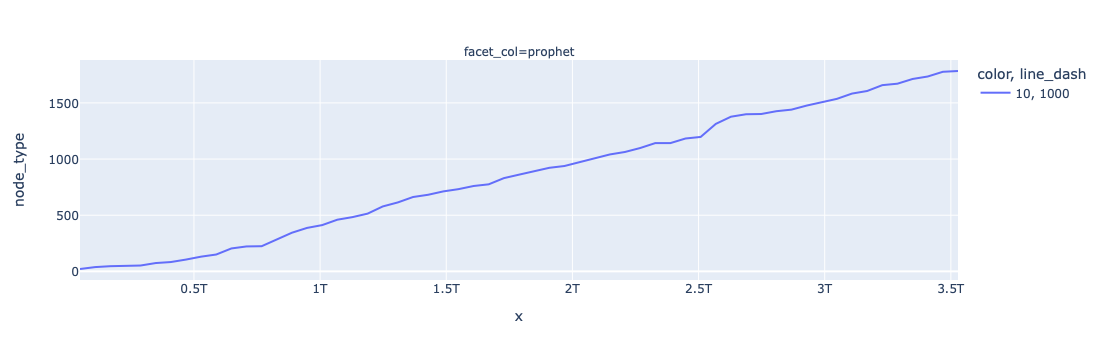

In [137]:
fig = px.line(
    reception_df,
    x=reception_df.index.get_level_values(3),
    y='node_type',
    color=reception_df.index.get_level_values(2),
    line_dash=reception_df.index.get_level_values(1),
    facet_col=reception_df.index.get_level_values(0),
    category_orders={
        "routing": ["Epidemic", "prophet", "dtlsr", "binary_spray", "context_epidemic", "context_spray", "cadr_responders"]
    }
)
fig
#fig.write_image("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/transmissions.pdf", width=1100, height=450)

# Compute and plot Average End-to-End Delay

In [138]:
creation_instances = event_frame[event_frame.event == "creation"].groupby(["sim_instance_id"])
delivery_instances = event_frame[event_frame.event == "delivery"]

In [139]:
delivered_list = []
runtime_list = []
for sim_instance_id, instance in tqdm(creation_instances):
    deliveries_sid = delivery_instances[delivery_instances["sim_instance_id"] == sim_instance_id]
    
    for _, row in instance.iterrows():
        # Compute deliverys
        bundle = row["bundle"]
        deliveries = deliveries_sid[deliveries_sid["bundle"] == bundle]

        if "dtn://coordinator/" in bundle:
            was_delivered = len(deliveries) >= 25
        else:
            was_delivered = not deliveries.empty

        row_dict = {
            "sim_instance_id": sim_instance_id,
            "bundle": bundle,
            "delivered": was_delivered,
            "routing": row["routing"],
            "payload_size": row["payload_size"],
            "bundles_per_node": row["bundles_per_node"],
        }
        delivered_list.append(row_dict)
        
        
        # Compute runtimes
        if was_delivered:
            delivery_time = deliveries["timestamp"].min()
            creation_time = row["timestamp"]
            runtime = delivery_time - creation_time
            
            runtime_dict = {
                "sim_instance_id": sim_instance_id,
                "bundle": bundle,
                "runtime": (runtime.to_pytimedelta() / timedelta(milliseconds=1)) / 1000,
                "routing": row["routing"],
                "bundles_per_node": str(row["bundles_per_node"]),
                "payload_size": row["payload_size"]
            }
            runtime_list.append(runtime_dict)
        
delivered_df = pd.DataFrame(delivered_list)
runtime_df = pd.DataFrame(runtime_list)

100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


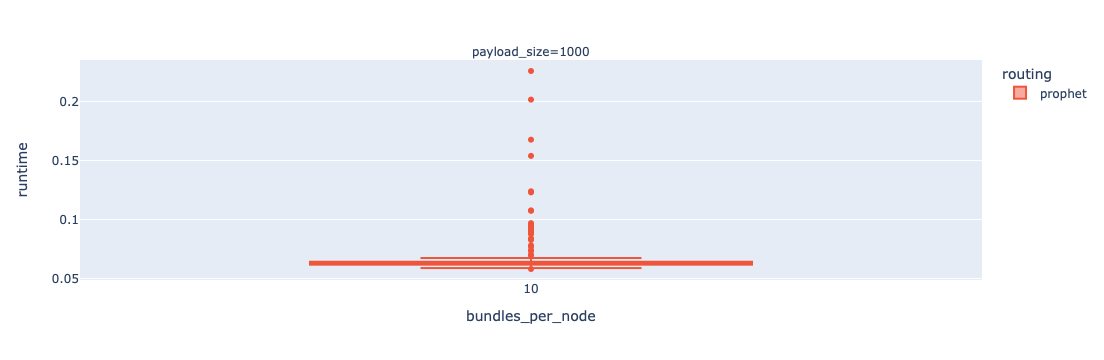

In [140]:
fig = px.box(
    runtime_df,
    x="bundles_per_node", 
    y="runtime",
    color="routing",
    facet_col="payload_size",
    category_orders={
        "routing": ["epidemic", "prophet", "dtlsr", "binary_spray", "context_epidemic", "context_spray", "cadr_responders"],
    }
)

fig
#fig.write_image("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/runtimes.pdf", width=1100, height=450)

# Compute and plot delivery ratio

In [141]:
ratio_df = pd.DataFrame()
for name, bundles in delivered_df.groupby(["routing", "sim_instance_id"]):
    routing, sim_instance_id = name
    total_bundles = len(bundles.index)
    delivered_bundles = len(bundles[bundles.delivered == True].index)
    payload_size = bundles["payload_size"].values[0]
    bundles_per_node = bundles["bundles_per_node"].values[0]
    row_dict = {
        "routing": routing,
        "sim_instance_id": sim_instance_id,
        "delivery_percentage": (float(delivered_bundles) / float(total_bundles)) * 100,
        "payload_size": payload_size,
        "bundles_per_node": str(bundles_per_node),
    }
    ratio_df = ratio_df.append([row_dict], ignore_index=True)

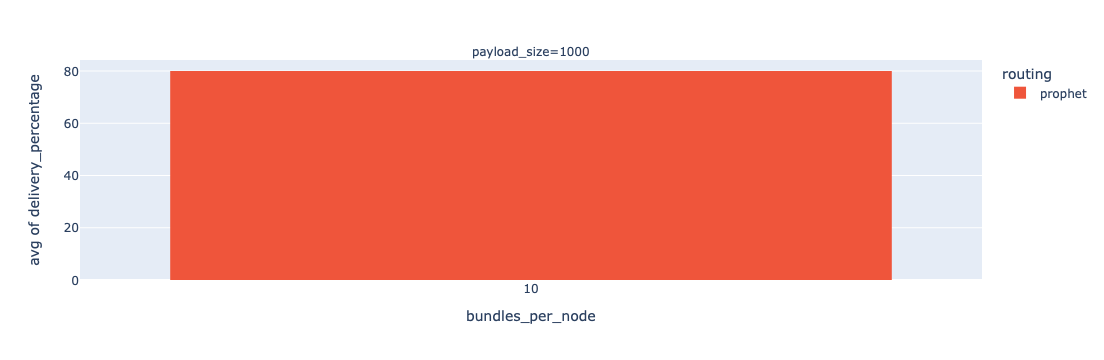

In [142]:
fig = px.histogram(
    ratio_df,
    x="bundles_per_node",
    y="delivery_percentage",
    color="routing",
    facet_col="payload_size",
    barmode='group',
    histfunc='avg',
    category_orders={
        "routing": ["epidemic", "prophet", "dtlsr", "binary_spray", "context_epidemic", "context_spray", "cadr_responders"]
    }
)

fig
#fig.write_image("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/delivery-ratio.pdf", width=1100, height=450)

In [185]:
routing_end_instances = event_frame[(event_frame.event == "routing_end") & (event_frame.meta == False)]
routing_end_instances["routing_time_ms"] = routing_end_instances["routing_time"] / pd.to_timedelta(1, unit='ms')

<ipython-input-185-9e942164833f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



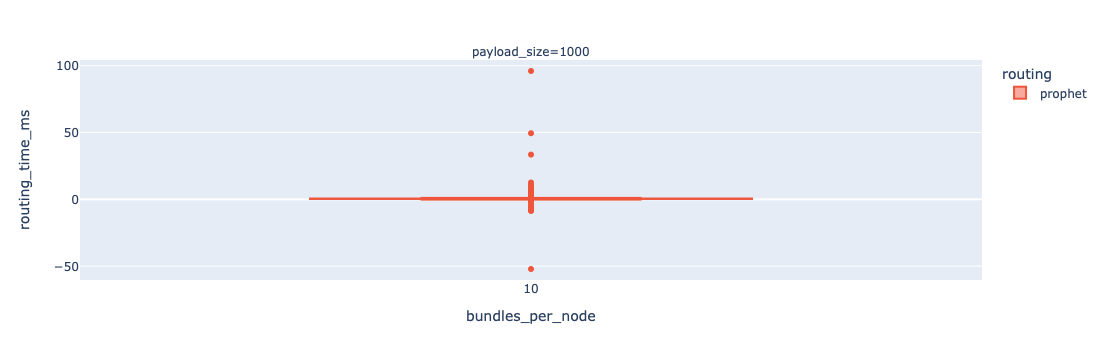

In [186]:
fig = px.box(
    routing_end_instances,
    x="bundles_per_node", 
    y="routing_time_ms",
    color="routing",
    facet_col="payload_size",
    category_orders={
        "routing": ["epidemic", "prophet", "dtlsr", "binary_spray", "context_epidemic", "context_spray", "cadr_responders"],
    }
)

fig
#fig.write_image("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/runtimes.pdf", width=1100, height=450)

In [143]:
meta_df = event_frame[((event_frame["event"] == "reception") | (event_frame["event"] == "delivery")) & (event_frame["meta"] == True)]
meta_df = meta_df.set_index("timestamp_relative")
meta_df = meta_df.groupby(["routing", "payload_size", "bundles_per_node"]).resample("1T").count()
meta_df = meta_df.drop(["routing", "payload_size", "bundles_per_node"], axis=1)
meta_df = meta_df.groupby(["routing", "payload_size", "bundles_per_node"]).cumsum()

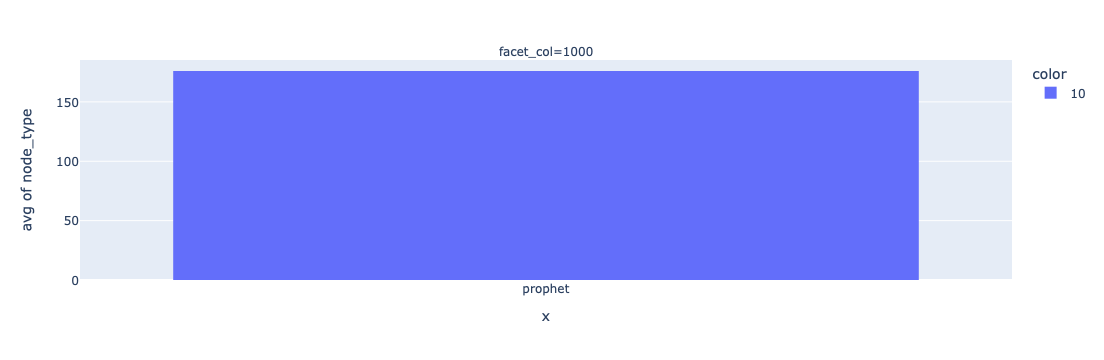

In [144]:
fig = px.histogram(
    meta_df,
    x=meta_df.index.get_level_values(0),
    y='node_type',
    color=meta_df.index.get_level_values(2),
    facet_col=meta_df.index.get_level_values(1),
    barmode='group',
    histfunc='avg',
)

fig
#fig.write_image("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/meta_overhead.pdf", width=1100, height=450)

In [238]:
meta_df = event_frame[((event_frame["event"] == "reception") | (event_frame["event"] == "delivery")) & (event_frame["meta"] == True)]
meta_df = meta_df.set_index("timestamp_relative")
meta_df = meta_df.groupby(["routing", "payload_size", "bundles_per_node"]).resample("1T").count()
meta_df = meta_df.drop(["routing", "payload_size", "bundles_per_node"], axis=1)
meta_df = meta_df.groupby(["routing", "payload_size", "bundles_per_node"]).cumsum()
meta_df.reset_index(level="timestamp_relative", inplace = True)

In [239]:
all_df = event_frame[((event_frame["event"] == "reception") | (event_frame["event"] == "delivery"))]
all_df = all_df.set_index("timestamp_relative")
all_df = all_df.groupby(["routing", "payload_size", "bundles_per_node"]).resample("1T").count()
all_df = all_df.drop(["routing", "payload_size", "bundles_per_node"], axis=1)
all_df = all_df.groupby(["routing", "payload_size", "bundles_per_node"]).cumsum()
all_df.reset_index(level="timestamp_relative", inplace = True)

In [242]:
overhead_df = all_df.join(meta_df, lsuffix="_all", rsuffix="_meta")
overhead_df.fillna(method='ffill', inplace=True)
overhead_df["overhead"] = overhead_df["node_meta"] / overhead_df["node_all"]

In [243]:
overhead_df.head()

timestamp_relative_all  \
routing payload_size bundles_per_node                          
prophet 1000         10               0 days 00:00:00.033020   
                     10               0 days 00:01:00.033020   
                     10               0 days 00:02:00.033020   
                     10               0 days 00:03:00.033020   
                     10               0 days 00:04:00.033020   

                                       sim_instance_id_all  timestamp_all  \
routing payload_size bundles_per_node                                       
prophet 1000         10                                183            183   
                     10                                216            216   
                     10                                231            231   
                     10                                243            243   
                     10                                246            246   

                                       event_all  node_all  bundle_all  \
routing payload_size bundles_per_node                                    
prophet 1000         10                      183       183         183   
                     10                      216       216         216   
                     10                      231       231         231   
                     10                      243       243         243   
                     10                      246       246         246   

                                       bundle_size_all  routing_time_all  \
routing payload_size bundles_per_node                                      
prophet 1000         10                            183               183   
                     10                            216               216   
                     10                            231               231   
                     10                            243               243   
                     10                            246               246   

                                       meta_all  meta_bundle_size_all  ...  \
routing payload_size bundles_per_node                                  ...   
prophet 1000         10                     183                   183  ...   
                     10                     216                   216  ...   
                     10                     231                   231  ...   
                     10                     243                   243  ...   
                     10                     246                   246  ...   

                                       timestamp_meta event_meta  node_meta  \
routing payload_size bundles_per_node                                         
prophet 1000         10                           176        176        176   
                     10                           176        176        176   
                     10                           176        176        176   
                     10                           176        176        176   
                     10                           176        176        176   

                                       bundle_meta  bundle_size_meta  \
routing payload_size bundles_per_node                                  
prophet 1000         10                        176               176   
                     10                        176               176   
                     10                        176               176   
                     10                        176               176   
                     10                        176               176   

                                       routing_time_meta  meta_meta  \
routing payload_size bundles_per_node                                 
prophet 1000         10                              176        176   
                     10                              176        176   
                     10                              176        176   
                     10             

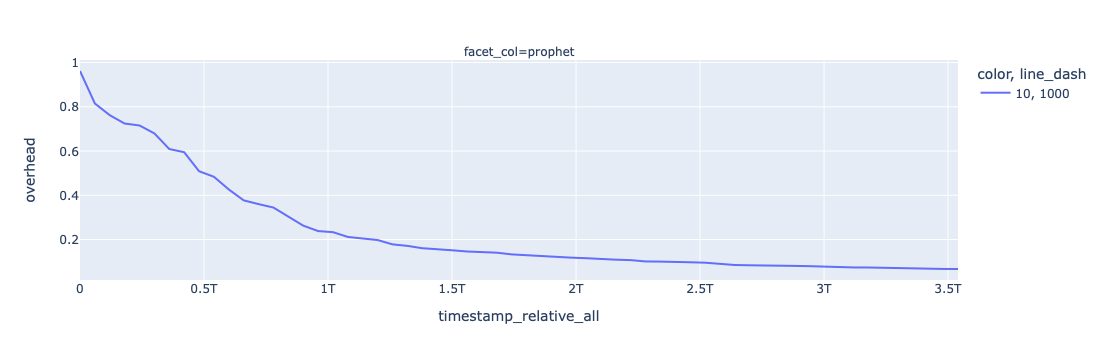

In [245]:
fig = px.line(
    overhead_df,
    x="timestamp_relative_all",
    y='overhead',
    color=overhead_df.index.get_level_values(2),
    line_dash=overhead_df.index.get_level_values(1),
    facet_col=overhead_df.index.get_level_values(0),
    category_orders={
        "routing": ["Epidemic", "prophet", "dtlsr", "binary_spray", "context_epidemic", "context_spray", "cadr_responders"]
    }
)
fig
#fig.write_image("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/transmissions.pdf", width=1100, height=450)

In [285]:
recv_bytes_df = event_frame[((event_frame["event"] == "reception") | (event_frame["event"] == "delivery"))]# & (event_frame["meta"] == True)]
recv_bytes_df = recv_bytes_df.set_index("timestamp_relative")
recv_bytes_df = recv_bytes_df.groupby(["routing", "payload_size", "bundles_per_node"]).agg({"meta_bundle_size": sum, "bundle_size": sum})
recv_bytes_df["overhead"] = (recv_bytes_df["meta_bundle_size"] / (recv_bytes_df["meta_bundle_size"] + recv_bytes_df["bundle_size"])) * 100

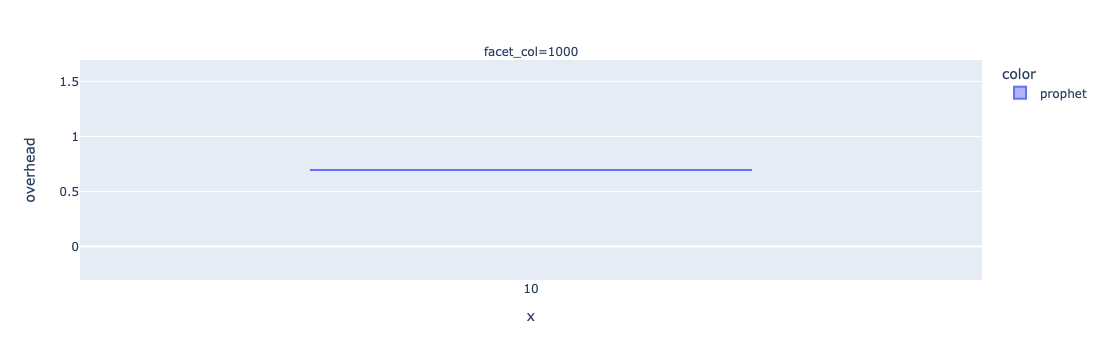

In [287]:
fig = px.box(
    recv_bytes_df,
    x=recv_bytes_df.index.get_level_values(2), 
    y="overhead",
    color=recv_bytes_df.index.get_level_values(0), 
    facet_col=recv_bytes_df.index.get_level_values(1), 
    category_orders={
        "routing": ["epidemic", "prophet", "dtlsr", "binary_spray", "context_epidemic", "context_spray", "cadr_responders"],
    }
)

fig
#fig.write_image("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/runtimes.pdf", width=1100, height=450)